## Comprehensive Natural Language Processing with Python

### Quora Insincere Questions Classification Challenge

### Problem Statement

Quora is a platform that empowers people to learn from each other. 

On Quora, people can ask questions and connect with others who contribute unique insights and quality answers. A key challenge is to weed out insincere questions -- those founded upon false premises, or that intend to make a statement rather than look for helpful answers.

We are tasked to develop NLP models that identify and flag insincere questions.

To date, Quora has employed both machine learning and manual review to address this problem.

#### Build scalable methods to derect toxic and misleading content to improve online conversations and combat online trolls at scale

Help Quora uphold their policy of “Be Nice, Be Respectful” and continue to be a place for sharing and growing the world’s knowledge.

#### Importing the Required Libraries and Getting our Systems Ready

In [1]:
import os
import numpy as np
import pandas as pd
import time
from tqdm import tqdm

import lightgbm as lgb

from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

import nltk
from nltk.corpus import stopwords
import string

from scipy.sparse import hstack

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:

import os
import string
import pickle
import random

from sklearn.feature_extraction.text import CountVectorizer
import nltk 
import string
import re
from nltk.corpus import stopwords

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer #  import TF-idf vectorizer
from sklearn.utils import shuffle # to shuffle the data 
import random # import random
import sklearn # import sklearn
import nltk # import nltk
from nltk.corpus import stopwords #import stop words
import re # import regular expression
from nltk.tokenize import word_tokenize # import word_tokenize

In [7]:
# Loading the Train and Test Sets

train = pd.read_csv('train.csv.zip')
test  = pd.read_csv('test.csv.zip')
full_data = [train, test]
print (train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
qid              1306122 non-null object
question_text    1306122 non-null object
target           1306122 non-null int64
dtypes: int64(1), object(2)
memory usage: 29.9+ MB
None


In [8]:
train.head(3)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0


### Data Understanding / Pre-Processing and  Transformation

#### Basic Text Pre-processing of text data
        Lower casing
        Punctuation removal
        Stopwords removal
        Frequent words removal
        Rare words removal
        Spelling correction
    Tokenization
        Stemming
        Lemmatization

In [20]:
print('Dataset size:',train.shape)
print('Columns are:',train.columns)

Dataset size: (1306122, 4)
Columns are: Index(['qid', 'question_text', 'target', 'Contains_capitalized'], dtype='object')


In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 4 columns):
qid                     1306122 non-null object
question_text           1306122 non-null object
target                  1306122 non-null int64
Contains_capitalized    1306122 non-null bool
dtypes: bool(1), int64(1), object(2)
memory usage: 31.1+ MB


In [8]:
train_target = train['target'].values

np.unique(train_target)

array([0, 1])

In [10]:
train.describe()

,target
count,1.306122e+06
mean,6.187018e-02
std,2.409197e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.000000e+00


###  Description of the Non-Numerical Columns

In [11]:
train.describe(include = ['O'])

,qid,question_text
count,1306122,1306122
unique,1306122,1306122
top,bcb70a87949a0df29882,What's the best way to invest your money and g...
freq,1,1


### Checking if the Tweeps Tweet Contains Capitalized Words

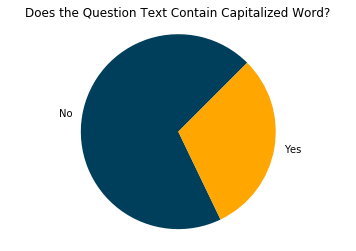

In [12]:
def contains_capitalized_word(s):
    for w in s.split():
        if w.isupper():
            return True
    return False


train['Contains_capitalized'] = train["question_text"].apply(contains_capitalized_word)

value_counts = train["Contains_capitalized"].value_counts().to_dict()
fig, ax = plt.subplots()
_ = ax.pie([value_counts[False], value_counts[True]], labels=['No', 'Yes'], 
           colors=['#003f5c', '#ffa600'], textprops={'color': '#040204'}, startangle=45)
_ = ax.axis('equal')
_ = ax.set_title('Does the Question Text Contain Capitalized Word?')

In [13]:
train["Contains_capitalized"].value_counts(normalize=True)

False    0.696326
True     0.303674
Name: Contains_capitalized, dtype: float64

### Distribution of the Target Class

First let us look at the distribution of the target variable to understand more about the imbalance and so on.

In [14]:
train['target'].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

In [12]:
sincere_q = (train['target'] == 0).sum()
insincere_q = (train['target'] == 1).sum()

sincere_q, insincere_q

(1225312, 80810)

Text(0, 0.5, 'Frequency')

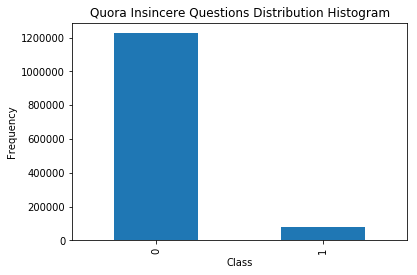

In [15]:
count_classes = pd.value_counts(train['target'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Quora Insincere Questions Distribution Histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [14]:
rate_sincere_q = (sincere_q/len(train['target']))*100
rate_insincere_q = (insincere_q/len(train['target']))*100
rate_sincere_q, rate_insincere_q
print( '{}% of questions are sincere and {}% are insincere'.format(rate_sincere_q, rate_insincere_q))

93.81298224821265% of questions are sincere and 6.187017751787352% are insincere


So about 6% of the training data are insincere questions (target=1) and rest of them are sincere.

###  Pre-Processing Text Data in Python 

Most of the text data are cleaned by following below steps.

Remove punctuations

Tokenization - Converting a sentence into list of words

Removing stopwords

Lammetization/stemming - Tranforming any form of a word to its root word

#### Remove punctuations

In [9]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [10]:
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

train['Tweet_punct'] = train['question_text'].apply(lambda x: remove_punct(x))
train.head(5)

,qid,question_text,target,Tweet_punct
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,How did Quebec nationalists see their province...
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,Do you have an adopted dog how would you encou...
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,Why does velocity affect time Does velocity af...
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,How did Otto von Guericke used the Magdeburg h...
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,Can I convert montra helicon D to a mountain b...


#### Tokenization

Tokenization is the process of segmenting running text into sentences and words. In essence, it’s the task of cutting a text into pieces called tokens, and at the same time throwing away certain characters, such as punctuation.

'''Tokenization refers to dividing the text into a sequence of words or sentences.'''


In [11]:
def tokenization(text):
    text = re.split('\W+', text)
    return text

train['Tweet_tokenized'] = train['Tweet_punct'].apply(lambda x: tokenization(x.lower()))
train.head(2)

,qid,question_text,target,Tweet_punct,Tweet_tokenized
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,How did Quebec nationalists see their province...,"[how, did, quebec, nationalists, see, their, p..."
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,Do you have an adopted dog how would you encou...,"[do, you, have, an, adopted, dog, how, would, ..."


#### Removing the Stopwords


Many sentences and paragraphs include words that have very little meaning or value. These words include “a,” “and,” “an,” and “the.” Stop word removal is a process of removing these words from a sentence or stream of words.

Stop words can be safely ignored by carrying out a lookup in a pre-defined list of keywords, freeing up database space and improving processing time.

In [19]:
import nltk
from nltk.corpus import stopwords

In [18]:
import nltk
nltk.download('stopwords')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
eng_stopwords = set(stopwords.words("english"))

In [14]:
stopword = nltk.corpus.stopwords.words('english')

In [16]:
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
train['Tweet_nonstop'] = train['Tweet_tokenized'].apply(lambda x: remove_stopwords(x))
train.head(3)

,qid,question_text,target,Tweet_punct,Tweet_tokenized,Tweet_nonstop
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,How did Quebec nationalists see their province...,"[how, did, quebec, nationalists, see, their, p...","[quebec, nationalists, see, province, nation]"
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,Do you have an adopted dog how would you encou...,"[do, you, have, an, adopted, dog, how, would, ...","[adopted, dog, would, encourage, people, adopt..."
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,Why does velocity affect time Does velocity af...,"[why, does, velocity, affect, time, does, velo...","[velocity, affect, time, velocity, affect, spa..."


####  Stemming

Stemming / lexicon normalization is the process of reducing noise in a word. It reduces inflection. For example, the word “fishing” has a stem word “fish.” Stemming is used to simplify a word down to its base meaning.

'''Stemming refers to the removal of suffices, like “ing”, “ly”, “s”, etc. by a simple rule-based approach. 

For this purpose, we will use PorterStemmer from the NLTK library.

In [18]:
ps = nltk.PorterStemmer()

def stemming(text):
    text = [ps.stem(word) for word in text]
    return text

train['Tweet_stemmed'] = train['Tweet_nonstop'].apply(lambda x: stemming(x))
train.head(3)

,qid,question_text,target,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,How did Quebec nationalists see their province...,"[how, did, quebec, nationalists, see, their, p...","[quebec, nationalists, see, province, nation]","[quebec, nationalist, see, provinc, nation]"
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,Do you have an adopted dog how would you encou...,"[do, you, have, an, adopted, dog, how, would, ...","[adopted, dog, would, encourage, people, adopt...","[adopt, dog, would, encourag, peopl, adopt, shop]"
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,Why does velocity affect time Does velocity af...,"[why, does, velocity, affect, time, does, velo...","[velocity, affect, time, velocity, affect, spa...","[veloc, affect, time, veloc, affect, space, ge..."


#### Lemmatization

Lemmatization is a more effective option than stemming because it converts the word into its root word, rather than just stripping the suffices.

In [19]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
wn = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text

train['Tweet_lemmatized'] = train['Tweet_nonstop'].apply(lambda x: lemmatizer(x))
train.head(3)

,qid,question_text,target,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed,Tweet_lemmatized
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,How did Quebec nationalists see their province...,"[how, did, quebec, nationalists, see, their, p...","[quebec, nationalists, see, province, nation]","[quebec, nationalist, see, provinc, nation]","[quebec, nationalist, see, province, nation]"
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,Do you have an adopted dog how would you encou...,"[do, you, have, an, adopted, dog, how, would, ...","[adopted, dog, would, encourage, people, adopt...","[adopt, dog, would, encourag, peopl, adopt, shop]","[adopted, dog, would, encourage, people, adopt..."
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,Why does velocity affect time Does velocity af...,"[why, does, velocity, affect, time, does, velo...","[velocity, affect, time, velocity, affect, spa...","[veloc, affect, time, veloc, affect, space, ge...","[velocity, affect, time, velocity, affect, spa..."


In [21]:
def clean_text(text):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return text

In [23]:
# Export the Cleaned Text Data to CSV

train.to_csv("CleanedSet.csv", index=False)

#### Vectorization
Cleaning data in single line through passing clean_text in the CountVectorizer

In [4]:
df = pd.read_csv('CleanedSet.csv')

In [5]:
df['target'].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
stopword = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

In [23]:
countVectorizer = CountVectorizer(analyzer=clean_text) 
countVector = countVectorizer.fit_transform(df['question_text'])
print('{} Number of question_text has {} words'.format(countVector.shape[0], countVector.shape[1]))

1306122 Number of question_text has 179523 words


In [ ]:
# print(countVectorizer.get_feature_names())

In [18]:
# Vectorization
 
#Importing Required Packages

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import gensim

## Advanced  Text Processing in  Python

#### Advance Text Processing Techniques 
        N-grams
        Term Frequency
        Inverse Document Frequency
        Term Frequency-Inverse Document Frequency (TF-IDF)
        Bag of Words
        Hashing with HashingVectorizer

### Applying Bag of Words to Text Data 

Bag of Words (BoW) refers to the representation of text which describes the presence of words within the text data. The intuition behind this is that two similar text fields will contain similar kind of words, and will therefore have a similar bag of words.

In [32]:
#Applying Bag of Words Vectorization to the Text Data

bow_vectorizer = CountVectorizer(stop_words= 'english')
bow = bow_vectorizer.fit_transform(df['Tweet_lemmatized'])

In [ ]:
#Using sklearn has a separate function to directly obtain TF and IDF 

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
 stop_words= 'english',ngram_range=(1,1))
train_vect = tfidf.fit_transform(df['Tweet_lemmatized'])

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
train_bow = bow.fit_transform(df['Tweet_lemmatized'])

#### Applying the TF-IDF Vectorization to the  Text Data

In [34]:
#Applying TF-IDF Vectorization to the Text Data
tfidf_vectorizer = TfidfVectorizer(stop_words= 'english')
tfidf = tfidf_vectorizer.fit_transform(df['Tweet_lemmatized'])

#### Hashing with HashingVectorizer

Counts and frequencies can be very useful, but one limitation of these methods is that the vocabulary can become very large.

This, in turn, will require large vectors for encoding documents and impose large requirements on memory and slow down algorithms.

A clever work around is to use a one way hash of words to convert them to integers. The clever part is that no vocabulary is required and you can choose an arbitrary-long fixed length vector. 
A downside is that the hash is a one-way function so there is no way to convert the encoding back to a word (which may not matter for many supervised learning tasks).
'''

In [27]:
from sklearn.feature_extraction.text import HashingVectorizer
# create the transform
vectorizer = HashingVectorizer(n_features=100)
vector = vectorizer.fit_transform(df['Tweet_lemmatized'])

### N-grams 

'''N-grams are the combination of multiple words used together. Ngrams with N=1 are called unigrams. 

Similarly, bigrams (N=2), trigrams (N=3) and so on can also be used. '''

In [ ]:
from textblob import TextBlob
TextBlob(df['question_text'][0]).ngrams(2)

#### Term Frequency


'''Term frequency is simply the ratio of the count of a word present in a sentence, to the length of the sentence.

TF = (Number of times term T appears in the particular row) / (number of terms in that row)'''

In [7]:
tf1 = (df['question_text'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['words','tf']
tf1

,words,tf
0,you,2
1,not,1
2,have,1
3,and,1
4,encourage,1
5,how,1
6,an,1
7,adopted,1
8,shop?,1
9,adopt,1


#### Inverse Document Frequency
'''
The intuition behind inverse document frequency (IDF) is that a word is not of much use to us if it’s appearing in all the documents.

The IDF of each word is the log of the ratio of the total number of rows to the number of rows in which that word is present.

IDF = log(N/n), where, N is the total number of rows and n is the number of rows in which the word was present.
'''

In [8]:
for i,word in enumerate(tf1['words']):
  tf1.loc[i, 'idf'] = np.log(df.shape[0]/(len(df[df['question_text'].str.contains(word)])))

tf1

,words,tf,idf
0,you,2,1.791759
1,not,1,3.044522
2,have,1,2.708050
3,and,1,1.386294
4,encourage,1,7.786967
5,how,1,3.583519
6,an,1,0.000000
7,adopted,1,8.207402
8,shop?,1,2.890372
9,adopt,1,7.021976


#### Term Frequency – Inverse Document Frequency (TF-IDF)

In [34]:
#Term Frequency – Inverse Document Frequency (TF-IDF)
tf1['tfidf'] = tf1['tf'] * tf1['idf']
tf1

,words,tf,idf,tfidf
0,you,2,1.791759,3.583519
1,not,1,3.044522,3.044522
2,have,1,2.708050,2.708050
3,and,1,1.386294,1.386294
4,encourage,1,7.786967,7.786967
5,how,1,3.583519,3.583519
6,an,1,0.000000,0.000000
7,adopted,1,8.207402,8.207402
8,shop?,1,2.890372,2.890372
9,adopt,1,7.021976,7.021976


In [9]:
# Using sklearn has a separate function to directly obtain TF and IDF 

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
 stop_words= 'english',ngram_range=(1,1))
train_vect = tfidf.fit_transform(df['question_text'])

## Feature Engineering in Text

For EDA and later Modelling Purposes, it might be a good idea to create some metafeatures. The metafeatures that we'll create are:

Number of words in the text

Number of unique words in the text

Number of characters in the text

Number of stopwords

Number of punctuations

Number of upper case words

Number of title case words

Average length of the words

Number of Special Characters

Number of Numerics



In [14]:
print('Average word length of questions in train is {0:.0f}.'.format(np.mean(df['question_text'].apply(lambda x: len(x.split())))))

Average word length of questions in train is 13.


In [15]:
print('Average character length of questions in train is {0:.0f}.'.format(np.mean(df['question_text'].apply(lambda x: len(x)))))

Average character length of questions in train is 71.


In [16]:
print('Max word length of questions in train is {0:.0f}.'.format(np.max(df['question_text'].apply(lambda x: len(x.split())))))

Max word length of questions in train is 134.


### Basic  Feature Extraction with Python 

In [17]:
eng_stopwords = set(stopwords.words("english"))

In [18]:
## Number of words in the text ##
df["num_words"] = df["question_text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
df["num_unique_words"] = df["question_text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
df["num_chars"] = df["question_text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
df["num_stopwords"] = df["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of punctuations in the text ##
df["num_punctuations"] =df['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
df["num_words_upper"] = df["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))


## Number of title case words in the text ##
df["num_words_title"] = df["question_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
df["mean_word_len"] = df["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

### Generating Count Based And Demographical Features

In [19]:
from tqdm import tqdm 
print(">> Generating Count Based And Demographical Features")
for df in ([df]):
    df['length'] = df['question_text'].apply(lambda x : len(x))
    df['capitals'] = df['question_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['length']),axis=1)
    df['num_exclamation_marks'] = df['question_text'].apply(lambda comment: comment.count('!'))
    df['num_question_marks'] = df['question_text'].apply(lambda comment: comment.count('?'))
    df['num_punctuation'] = df['question_text'].apply(lambda comment: sum(comment.count(w) for w in '.,;:'))
    df['num_symbols'] = df['question_text'].apply(lambda comment: sum(comment.count(w) for w in '*&$%'))
    df['num_words'] = df['question_text'].apply(lambda comment: len(comment.split()))
    df['num_unique_words'] = df['question_text'].apply(lambda comment: len(set(w for w in comment.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['num_words']
    df['num_smilies'] = df['question_text'].apply(lambda comment: sum(comment.count(w) for w in (':-)', ':)', ';-)', ';)')))
    df['num_sad'] = df['question_text'].apply(lambda comment: sum(comment.count(w) for w in (':-<', ':()', ';-()', ';(')))

>> Generating Count Based And Demographical Features


#### Let's have a glance at new features ...

In [20]:
df[df.columns[8:]].head(8)

,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len,length,capitals,caps_vs_length,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,words_vs_unique,num_smilies,num_sad
0,13,13,72,7,1,0,2,4.615385,72,2,0.027778,0,1,0,0,1.000000,0,0
1,16,15,81,9,2,0,1,4.125000,81,1,0.012346,0,1,1,0,0.937500,0,0
2,10,8,67,3,2,0,2,5.800000,67,2,0.029851,0,2,0,0,0.800000,0,0
3,9,9,57,3,1,0,4,5.444444,57,4,0.070175,0,1,0,0,1.000000,0,0
4,15,15,77,8,1,2,3,4.200000,77,3,0.038961,0,1,0,0,1.000000,0,0
5,10,10,72,3,2,0,6,6.300000,72,6,0.083333,0,1,1,0,1.000000,0,0
6,18,17,113,10,2,0,2,5.333333,113,2,0.017699,0,1,1,0,0.944444,0,0
7,14,14,69,7,2,1,3,4.000000,69,3,0.043478,0,1,1,0,1.000000,0,0


##### Creating a Clean and Feature Engineered dataset 

In [21]:
# Export the Cleaned Text Data to CSV

df.to_csv("FeatureENg.csv", index=False)

In [11]:
dfeature = pd.read_csv('FeatureENg.csv')

In [12]:
dfeature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 26 columns):
qid                      1306122 non-null object
question_text            1306122 non-null object
target                   1306122 non-null int64
Tweet_punct              1306121 non-null object
Tweet_tokenized          1306122 non-null object
Tweet_nonstop            1306122 non-null object
Tweet_stemmed            1306122 non-null object
Tweet_lemmatized         1306122 non-null object
num_words                1306122 non-null int64
num_unique_words         1306122 non-null int64
num_chars                1306122 non-null int64
num_stopwords            1306122 non-null int64
num_punctuations         1306122 non-null int64
num_words_upper          1306122 non-null int64
num_words_title          1306122 non-null int64
mean_word_len            1306122 non-null float64
length                   1306122 non-null int64
capitals                 1306122 non-null int64
caps_vs_length